Random Forest
=======

Libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

from scipy import interp

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(200000)

In [3]:
data = data.reset_index()
data = data.drop("index", axis = 1)

In [4]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,3.0,6.0,D,1855.0,0.0,9.0,0.0,16525.0,0.0,14842.0,...,2.0,15494.0,68.1,66.7,D1,0.0,6.0,19.72,RENT,0.0
1,4.0,4.0,C,4914.0,0.0,8.0,0.0,10000.0,0.0,73717.0,...,0.0,103714.0,92.6,100.0,C1,0.0,5.0,25.05,RENT,0.0
2,8.0,8.0,E,2154.0,0.0,40.0,0.0,12500.0,0.0,25844.0,...,5.0,23453.0,84.1,50.0,E1,0.0,10.0,29.41,OWN,0.0
3,3.0,7.0,A,774.0,0.0,17.0,0.0,8000.0,0.0,12379.0,...,0.0,10479.0,59.1,33.3,A3,0.0,15.0,24.62,RENT,0.0
4,3.0,5.0,B,3750.0,0.0,10.0,0.0,17000.0,3.0,33747.0,...,5.0,67221.0,79.8,66.7,B5,2.0,5.0,9.73,MORTGAGE,0.0


In [5]:
data.shape

(200000, 50)

Data balance:

In [6]:
data['loan_status'].value_counts()

0.0    158681
1.0     41319
Name: loan_status, dtype: int64

#### Pre-processing:

Categorical_variables

In [7]:
categorical_variables = data.select_dtypes(include="object").columns

In [8]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [9]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [10]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,3.0,6.0,0.305666,1855.0,0.0,9.0,0.0,16525.0,0.0,14842.0,...,2.0,15494.0,68.1,66.7,0.290027,0.0,6.0,19.72,0.241486,0.0
1,4.0,4.0,0.225472,4914.0,0.0,8.0,0.0,10000.0,0.0,73717.0,...,0.0,103714.0,92.6,100.0,0.188188,0.0,5.0,25.05,0.241486,0.0
2,8.0,8.0,0.389722,2154.0,0.0,40.0,0.0,12500.0,0.0,25844.0,...,5.0,23453.0,84.1,50.0,0.359398,0.0,10.0,29.41,0.217132,0.0
3,3.0,7.0,0.065236,774.0,0.0,17.0,0.0,8000.0,0.0,12379.0,...,0.0,10479.0,59.1,33.3,0.060966,0.0,15.0,24.62,0.241486,0.0
4,3.0,5.0,0.135096,3750.0,0.0,10.0,0.0,17000.0,3.0,33747.0,...,5.0,67221.0,79.8,66.7,0.169787,2.0,5.0,9.73,0.176636,0.0


In [11]:
data.shape

(200000, 50)

Target:

In [12]:
X = data.loc[:, data.columns!='loan_status']

In [13]:
y = data['loan_status']

Random Forest
=======
__________

In [14]:
random_forest = RandomForestClassifier(n_estimators = 50)

Parameters to randomize:

In [15]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, 10],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

Randomize search with Cross Validation:

In [16]:
random_search = RandomizedSearchCV(random_forest, n_iter=50, param_distributions=param_dist,
                                   cv=3, scoring="roc_auc", n_jobs=4, verbose=1)

In [17]:
random_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 57.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'max_depth': [3, 10], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0b0a07b828>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0b0a079cf8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0b0a075588>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,

__Cross Validation Results:__

In [18]:
pd.set_option('display.max_columns', None)
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,66.146000,2.330133,0.795970,0.827121,True,entropy,10,6,8,9,"{'bootstrap': True, 'criterion': 'entropy', 'm...",13,0.794920,0.826258,0.795271,0.828150,0.797720,0.826954,1.673283,0.216155,0.001245,0.000781
1,20.407706,0.767097,0.758635,0.760072,True,entropy,3,6,10,6,"{'bootstrap': True, 'criterion': 'entropy', 'm...",36,0.756302,0.758727,0.758383,0.761516,0.761220,0.759972,3.817136,0.194953,0.002016,0.001141
2,38.867729,1.139304,0.755641,0.756669,True,entropy,3,8,7,8,"{'bootstrap': True, 'criterion': 'entropy', 'm...",37,0.763670,0.765222,0.748391,0.751644,0.754862,0.753141,0.137328,0.091225,0.006262,0.006078
3,38.522825,1.206370,0.764922,0.766207,True,entropy,3,7,7,2,"{'bootstrap': True, 'criterion': 'entropy', 'm...",32,0.762532,0.764799,0.758614,0.761058,0.773621,0.772765,0.322359,0.035558,0.006356,0.004882
4,60.645485,1.130119,0.766360,0.767326,False,entropy,3,10,10,5,"{'bootstrap': False, 'criterion': 'entropy', '...",30,0.771683,0.774016,0.766890,0.768835,0.760508,0.759128,2.255821,0.023884,0.004577,0.006171
5,52.680042,1.155160,0.745207,0.746782,False,gini,3,10,7,3,"{'bootstrap': False, 'criterion': 'gini', 'max...",44,0.745763,0.747958,0.744066,0.747290,0.745794,0.745099,0.090256,0.092541,0.000807,0.001221
6,217.797135,2.428211,0.801400,0.830915,False,entropy,10,10,6,6,"{'bootstrap': False, 'criterion': 'entropy', '...",2,0.801641,0.831047,0.800106,0.831702,0.802452,0.829996,4.865453,0.205519,0.000973,0.000703
7,132.771083,2.511224,0.796655,0.835925,False,gini,10,8,8,4,"{'bootstrap': False, 'criterion': 'gini', 'max...",11,0.796152,0.836572,0.795056,0.835911,0.798758,0.835291,2.174732,0.052597,0.001553,0.000523
8,86.675782,2.465424,0.793524,0.827127,True,gini,10,7,10,8,"{'bootstrap': True, 'criterion': 'gini', 'max_...",17,0.792151,0.826927,0.792018,0.827754,0.796403,0.826701,0.663912,0.158545,0.002036,0.000452
9,19.065692,1.202951,0.736567,0.738075,True,entropy,3,3,6,8,"{'bootstrap': True, 'criterion': 'entropy', 'm...",47,0.747114,0.751115,0.733574,0.736935,0.729012,0.726175,1.010641,0.228387,0.007687,0.010213


In [19]:
random_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [20]:
random_search.best_score_

0.8021774742350843

Feature importance:

Text(0.5,1,'Feature importance')

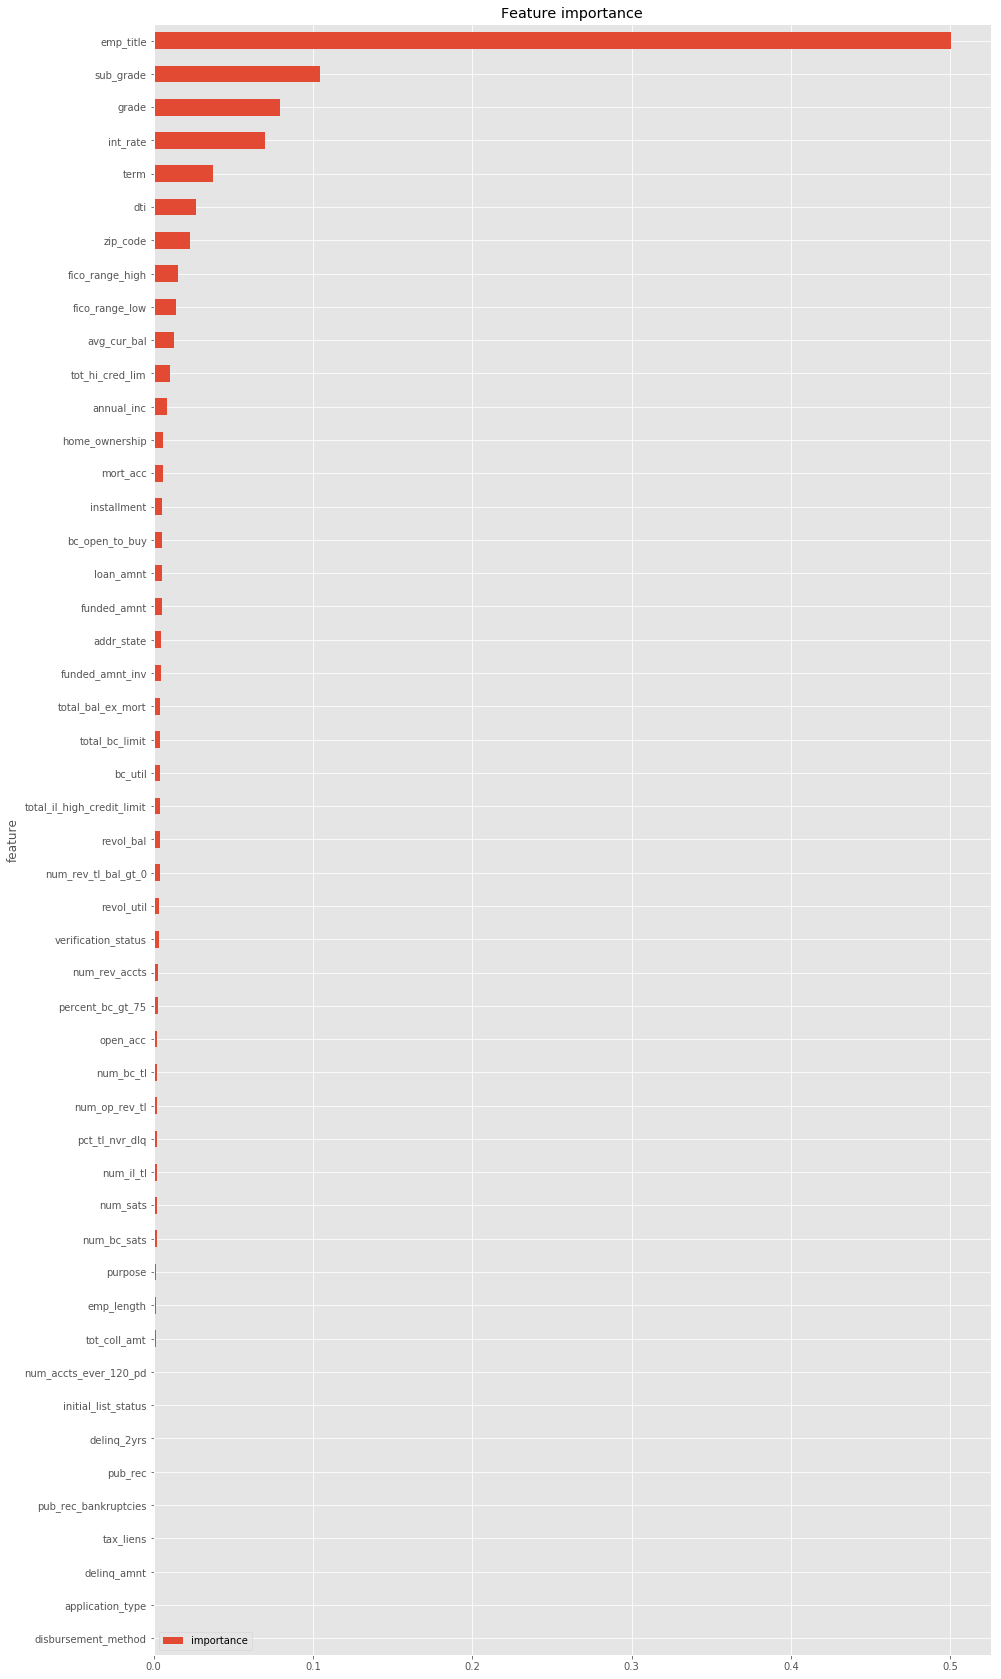

In [21]:
features = pd.DataFrame({'feature':X.columns,
                         'importance':random_search.best_estimator_.feature_importances_})

features = features.set_index('feature').sort_values('importance', ascending=True)

features.plot(kind='barh',figsize=(15,30)).set_title('Feature importance')

As we already concluded in the feature engineering part of the project, the `emp_title` has a very positive impact in the model. Other categorical variables such `sub_grade`, `grade` or `zip_code` are very important ones in the model (considering them as the ratio of unpaid/paid loan per category).

Model Evaluation
==========
_________________

Run classifier with cross-validation and plot __ROC curves__:

In [22]:
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=10,
                                    max_features=10, min_samples_leaf=2, min_samples_split=3,
                                    n_estimators=200)

In [23]:
# dataframes to numpy arrays
X = X.values
y = y.values

The following source code to plot ROC curves have been downloaded from [sklearn API](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) with some metrics have been added for each cross validation split:

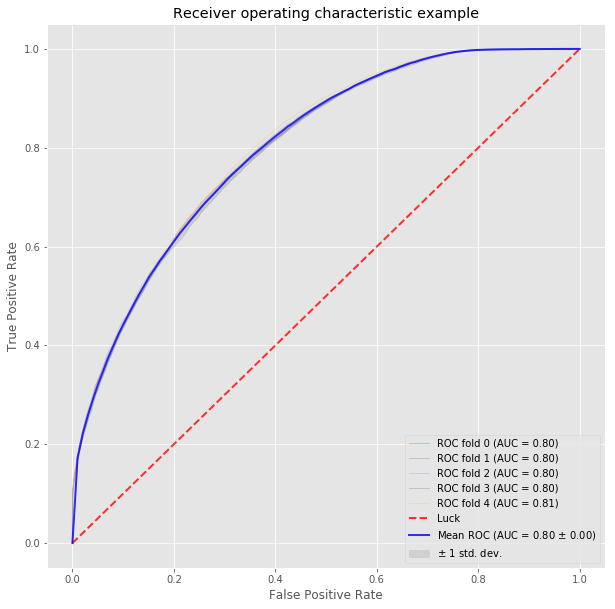

In [24]:
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

i = 0
for train, test in cv.split(X, y):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    # accuracy
    predictions_ = classifier.predict(X[test])
    accuracy = accuracy_score(y[test], predictions_)
    accuracies.append(accuracy)
    
    # precisions
    precision = precision_recall_fscore_support(y[test], predictions_)[0][1]
    precisions.append(precision)
    
    # recall
    recall = precision_recall_fscore_support(y[test], predictions_)[1][1]
    recalls.append(recall)
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Metrics__ in the test set:

In [25]:
metrics = pd.DataFrame(
    {"auc": aucs,
     "accuracy": accuracies, 
     "precision": precisions, 
     "recall": recalls
    })

In [26]:
metrics

,accuracy,auc,precision,recall
0,0.822029,0.803720,0.800210,0.184656
1,0.821225,0.800348,0.785824,0.185140
2,0.821275,0.803616,0.809207,0.176549
3,0.820200,0.799385,0.787863,0.177517
4,0.821921,0.807288,0.800316,0.183832


In [27]:
metrics.apply(lambda i: np.mean(i), axis = 0)

accuracy     0.821330
auc          0.802871
precision    0.796684
recall       0.181539
dtype: float64